In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/mini_project

/content/drive/MyDrive/Colab Notebooks/mini_project


In [3]:
data = pd.read_excel('dataset_cloth_recom.xlsx')

In [4]:
print(data.head(10))

   fit  user_id bust size  item_id  weight  ...  category height  size    age product
0  fit   420272       34d  2260466  137lbs  ...    romper  5' 8"  14.0   28.0   1.jpg
1  fit   273551       34b   153475  132lbs  ...      gown  5' 6"  12.0   36.0   2.jpg
2  fit   360448       NaN  1063761     NaN  ...    sheath  5' 4"   4.0  116.0  15.jpg
3  fit   909926       34c   126335  135lbs  ...     dress  5' 5"   8.0   34.0   4.jpg
4  fit   151944       34b   616682  145lbs  ...      gown  5' 9"  12.0   27.0   5.jpg
5  fit   734848       32b   364092  138lbs  ...     dress  5' 8"   8.0   45.0   6.jpg
6  fit   336066       34c   568429  112lbs  ...     dress  5' 3"   4.0   27.0   7.jpg
7  fit    86661      34d+   130259  118lbs  ...     dress  5' 3"   8.0   65.0   8.jpg
8  fit   166228       36d  1729232     NaN  ...      gown  5' 6"  21.0   27.0   9.jpg
9  fit   126461       36c   132135  129lbs  ...      gown  5' 6"   7.0   20.0  10.jpg

[10 rows x 15 columns]


In [5]:
data.dtypes

fit                object
user_id             int64
bust size          object
item_id             int64
weight             object
rating              int64
rented for         object
review_text        object
body type          object
review_summary     object
category           object
height             object
size              float64
age               float64
product            object
dtype: object

In [6]:
pip install surprise

     |████████████████████████████████| 11.8 MB 20.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630067 sha256=86e97b13fdd0bfb6644d6e54d9c3f9557f810fc677d4e2cd53a0e6a32336cf30
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [7]:
from surprise import Dataset
from surprise import Reader
import os, io
from surprise import SVD
from surprise import accuracy

In [8]:
train, test = train_test_split(data, test_size=0.2)

In [9]:
def preprocessAge(data):
  bins = pd.IntervalIndex.from_tuples([(5, 15), (15, 30), (30, 50),(50,65),(65,100)])
  x = pd.cut(data['age'].to_list(), bins)
  x.categories = ['1','2','3','4','5']
  data['age_bins']  = x
  age_Preprocessed_data = data[~data['age_bins'].isnull()]
  # print ('{0} rows got dropped after age preprocessing'.format(str(data.shape[0] - age_Preprocessed_data.shape[0])))
  return age_Preprocessed_data

In [10]:
def preprocessBustsize(age_Preprocessed_data):
  data_bust_size_not_null = age_Preprocessed_data[~age_Preprocessed_data['bust size'].isnull()]
  data_bust_size_not_null['bust size'] = data_bust_size_not_null['bust size'].apply(lambda x : (int(x[:2]), x[2:]))
  data_bust_size_not_null.shape
  data_bust_size_not_null[['bust Size1', 'bust']] = pd.DataFrame(data_bust_size_not_null['bust size'].tolist(), index=data_bust_size_not_null.index)
  bustDict = {'a': 1, 'aa': 1, 'b': 2, 'c': 3, 'd': 4, 
            'd+': 5, 'dd': 5, 'ddd/e': 6,
           'f':7 , 'g': 8, 'h': 9, 'i': 10, 'j': 11}
  data_bust_size_not_null['bust1'] = data_bust_size_not_null['bust'].map(bustDict)
  # Calculating model of bust size based on age grp.
  def funct(df):
    return df.mode()
  x = data_bust_size_not_null[['age_bins','bust Size1','bust1']].groupby('age_bins').apply(funct)
  x.reset_index(inplace= True, drop = True)
  data_bust_size_null = age_Preprocessed_data[age_Preprocessed_data['bust size'].isnull()]
  data_bust_size_null = pd.merge(data_bust_size_null, x, how ='left', left_on = 'age_bins', right_on = 'age_bins')
  data_bust_size_cleansed = data_bust_size_not_null.append(data_bust_size_null)
  return data_bust_size_cleansed

In [11]:
def preprocessHeight(data_bust_size_cleansed):
  data_bust_size_cleansed['heightCM'] = data_bust_size_cleansed['height'].apply(lambda x : (int(x.split("\'")[0]) * 30.48) + (int(x.split("\'")[1][:-1]) * 2.54) 
                                                        if type(x) == str else x)
  data_bust_size_cleansed['heightCM'].fillna((data_bust_size_cleansed['heightCM'].mean()), inplace=True)
  return data_bust_size_cleansed

In [12]:
def preprocessWeight(data_bust_size_cleansed):
  data_bust_size_cleansed['weightLbs'] = data_bust_size_cleansed['weight'].apply(lambda x : int(x[:-3])                                                        if type(x) == str else x)
  data_bust_size_cleansed['weightLbs'].fillna((data_bust_size_cleansed['weightLbs'].mean()), inplace=True)
  return data_bust_size_cleansed

In [13]:
def preprocessRentedFor(data_bust_size_cleansed):
  data_bust_size_cleansed['rented for'].fillna('other', inplace=True)
  return data_bust_size_cleansed

In [14]:
def preprocessBodytype(data_bust_size_cleansed):
  # Calculating model of body type based on Bust Size.
  data_body_type_not_null = data_bust_size_cleansed[~data_bust_size_cleansed['body type'].isnull()]
  def func(df):
    return df.mode()
  x = data_body_type_not_null[['bust Size1','body type']].groupby('bust Size1').apply(func)
  x.reset_index(inplace= True, drop = True)
  # print(x)
  data_body_type_null = data_bust_size_cleansed[data_bust_size_cleansed['body type'].isnull()]
  data_body_type_null = pd.merge(data_body_type_null, x, how ='left', left_on = 'bust Size1', right_on = 'bust Size1')
  # print(data_body_type_null)
  data_body_type_cleansed = data_body_type_not_null.append(data_body_type_null,sort=True)
  # print(data_body_type_cleansed)
  data_body_type_cleansed['body type'].fillna(data_body_type_cleansed['body type_y'], inplace=True)
  del data_body_type_cleansed['body type_x']
  del data_body_type_cleansed['body type_y']
  return data_body_type_cleansed

In [15]:
def createFinalDataframe(cleansedData):
  final_df=cleansedData.copy()
  final_df=final_df.drop(['rented for','rating','category','age_bins','bust','bust size','fit','height','item_id','review_summary','user_id','weight','review_text'],axis=1)
  cleanup_nums = {"body type":     {"hourglass": 1, "straight & narrow": 2, "pear": 3,"athletic": 4, "full bust": 5,"petite": 6, "apple": 7}}
  final_df.replace(cleanup_nums, inplace=True)
  return final_df

In [16]:
def createFinalTestDataframe(cleansedData):
  final_df=cleansedData.copy()
  final_df=final_df.drop(['rating','category','age_bins','bust','bust size','fit','height','item_id','review_summary','weight','review_text'],axis=1)
  cleanup_nums = {"body type":     {"hourglass": 1, "straight & narrow": 2, "pear": 3,"athletic": 4, "full bust": 5,"petite": 6, "apple": 7}}
  final_df.replace(cleanup_nums, inplace=True)
  return final_df

In [17]:
age_Preprocessed_data=preprocessAge(train)
data_bust_size_cleansed=preprocessBustsize(age_Preprocessed_data)
data_bust_size_cleansed=preprocessHeight(data_bust_size_cleansed)
data_bust_size_cleansed=preprocessWeight(data_bust_size_cleansed)
data_bust_size_cleansed=preprocessRentedFor(data_bust_size_cleansed)
cleansedData=preprocessBodytype(data_bust_size_cleansed)
final_df=createFinalDataframe(cleansedData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [18]:
feature_names = ['age', 'bust Size1','bust1','size','heightCM','weightLbs']
X = final_df[feature_names]
y = final_df['body type']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [19]:
print(X)

      age  bust Size1  bust1  size  heightCM   weightLbs
45   20.0        32.0      2   4.0    177.80  125.000000
100  28.0        34.0      4  16.0    154.94  145.000000
22   27.0        32.0      1   1.0    152.40  105.000000
33   36.0        32.0      4   8.0    167.64  125.000000
5    45.0        32.0      2   8.0    172.72  138.000000
..    ...         ...    ...   ...       ...         ...
1    27.0        32.0      3   8.0    160.02  128.000000
2    29.0        36.0      5  28.0    160.02  138.157143
3    33.0        36.0      3  12.0    165.10  145.000000
4    35.0        34.0      2  24.0    165.10  165.000000
5    32.0        34.0      2   1.0    160.02  115.000000

[81 rows x 6 columns]


In [20]:
print(y)

45     2
100    3
22     4
33     3
5      4
      ..
1      4
2      4
3      4
4      4
5      4
Name: body type, Length: 81, dtype: int64


In [21]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
model.fit(X_train, y_train)
#y_pred = model.predict(X_test)
#print(classification_report(y_test, y_pred))
print('Accuracy of Random forest classifier on training set: {:.2f}'
    .format(model.score(X_train, y_train)))
print('Accuracy of Random forest classifier on test set: {:.2f}'
     .format(model.score(X_test, y_test)))


Accuracy of Random forest classifier on training set: 1.00
Accuracy of Random forest classifier on test set: 0.29


In [ ]:
'''
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))
#print('Accuracy of Logistic regression classifier on training set: {:.2f}'
 #    .format(logreg.score(X_train, y_train)))
#print('Accuracy of Logistic regression classifier on test set: {:.2f}'
 #    .format(logreg.score(X_test, y_test)))
'''

"\nfrom sklearn.linear_model import LogisticRegression\nlogreg = LogisticRegression()\nlogreg.fit(X_train, y_train)\ny_pred = logreg.predict(X_test)\nprint(classification_report(y_test, y_pred))\n#print('Accuracy of Logistic regression classifier on training set: {:.2f}'\n #    .format(logreg.score(X_train, y_train)))\n#print('Accuracy of Logistic regression classifier on test set: {:.2f}'\n #    .format(logreg.score(X_test, y_test)))\n"

In [ ]:
'''
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred1 = knn.predict(X_test)
#print(confusion_matrix(y_test, y_pred1))
print(classification_report(y_test, y_pred1))
#print('Accuracy of K-NN classifier on training set: {:.2f}'
 #    .format(knn.score(X_train, y_train)))
#print('Accuracy of K-NN classifier on test set: {:.2f}'
 #    .format(knn.score(X_test, y_test)))
 '''

"\nfrom sklearn.neighbors import KNeighborsClassifier\n\nknn = KNeighborsClassifier()\nknn.fit(X_train, y_train)\ny_pred1 = knn.predict(X_test)\n#print(confusion_matrix(y_test, y_pred1))\nprint(classification_report(y_test, y_pred1))\n#print('Accuracy of K-NN classifier on training set: {:.2f}'\n #    .format(knn.score(X_train, y_train)))\n#print('Accuracy of K-NN classifier on test set: {:.2f}'\n #    .format(knn.score(X_test, y_test)))\n "

In [22]:
age_Preprocessed_testdata=preprocessAge(test)
testdata_bust_size_cleansed=preprocessBustsize(age_Preprocessed_testdata)
testdata_bust_size_cleansed=preprocessHeight(testdata_bust_size_cleansed)
testdata_bust_size_cleansed=preprocessWeight(testdata_bust_size_cleansed)
testdata_bust_size_cleansed=preprocessRentedFor(testdata_bust_size_cleansed)
cleansedTestData=preprocessBodytype(testdata_bust_size_cleansed)
final_test_df=createFinalTestDataframe(cleansedTestData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [23]:
feature_names = ['age', 'bust Size1','bust1','size','heightCM','weightLbs','rented for','user_id']
testdata = final_test_df[feature_names]

In [24]:
for col in testdata.columns:
    print(col)

age
bust Size1
bust1
size
heightCM
weightLbs
rented for
user_id


In [25]:
print(testdata)

      age  bust Size1  bust1  ...   weightLbs     rented for  user_id
80   32.0          36      4  ...  151.000000        wedding   588841
4    27.0          34      2  ...  145.000000        wedding   151944
55   32.0          34      3  ...  140.000000           work   356530
74   32.0          34      4  ...  115.000000  formal affair   262729
9    20.0          36      3  ...  129.000000          other   126461
21   34.0          34      4  ...  150.000000  formal affair    97848
32   31.0          36      3  ...  132.000000          party   142342
69   24.0          38      5  ...  210.000000          party   491589
103  32.0          36      1  ...  150.000000        wedding   329989
18   27.0          34      4  ...  155.000000  formal affair   507437
52   30.0          32      3  ...  135.000000        wedding    12347
72   77.0          36      3  ...  130.000000          other   861377
39   37.0          34      3  ...  160.000000        wedding   870389
92   32.0          3

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
#%cd ..

In [ ]:
#ls

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Predicted body type: ['athletic']
Recommended itemID: 131533.0
Recommended category: gown
Recommended product: 152.jpg
Occasion: wedding


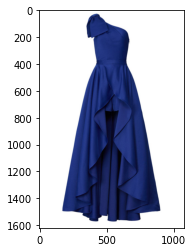

In [27]:
#cf_df=[]
for i in range(1):#len(testdata)
    age = testdata.iloc[i,0]
    bustSize1 = testdata.iloc[i,1]
    bust1 = testdata.iloc[i,2]
    size = testdata.iloc[i,3]
    heightCM = testdata.iloc[i,4]
    weightLbs = testdata.iloc[i,5]
    
    xnew=[[age,bustSize1,bust1,size,heightCM,weightLbs]]
    bodytypenumber=model.predict(xnew)
    #print("Predicted body type:",bodytypenumber)
    
    bodytypearray=["NaN","hourglass", "straight & narrow", "pear","athletic", "full bust","petite", "apple"]
    bodytype=np.asanyarray(bodytypearray)[bodytypenumber]
    print("Predicted body type:",bodytype)
    
    cluster_df=cleansedData.copy()
    groupedbybodytype = cluster_df.groupby('body type')
    for name,group in groupedbybodytype:
      if(bodytype==name):
        #print(name)
        #print(group)
        grouped_df=group.copy()
    rentedFor=testdata.iloc[i,6]
    
    groupedbybodytype = grouped_df.groupby('rented for')
    for name,group in groupedbybodytype:
      if(rentedFor==name):
        #print(name)
        #print(group)
        cf_df=group.copy()
    cf_df=cf_df[['user_id','item_id','rating']].copy()
    
    
    reader = Reader(rating_scale=(1,10))
    traindata=Dataset.load_from_df(cf_df,reader)
    trainingSet = traindata.build_full_trainset()
    
    svdAlgo = SVD(n_factors=200,n_epochs=50)
    svdAlgo.fit(trainingSet)
    
    itemid=cf_df['item_id'].unique()
    ratingOutput = pd.DataFrame(columns=['item_id', 'rating']) #Create a blank df with 2 columns at first and then append data
    
    for i in range(len(itemid)):
        user=cf_df.iloc[i,0] #User_id
        item=cf_df.iloc[i,1] #Item_id
        output=svdAlgo.predict(user,item,r_ui=None,clip=True,verbose=False)
        ratingOutput = ratingOutput.append({'item_id': item, 'rating': output.est}, ignore_index=True)
        
    ratingOutput=ratingOutput.sort_values('rating',ascending=False)
    outputdf=ratingOutput.head(10).copy()
    #print("Top 10 recommended items with their predicted ratings:")
    #outputdf.head()
    rawdf = pd.read_excel("dataset_cloth_recom.xlsx")
    itemID=outputdf['item_id'].iloc[0]#.astype('int64')
    print("Recommended itemID:",itemID)
    finaldf = (rawdf[rawdf['item_id']==itemID].iloc[0])
    print("Recommended category:",finaldf['category'])
    finalpro = (rawdf[rawdf['item_id']==itemID].iloc[0])
    print("Recommended product:",finaldf['product'])
    print("Occasion:",finaldf['rented for'])
    plt.imshow(mpimg.imread(finaldf['product']))
    


In [31]:
import pickle
with open('model.pkl','wb') as file:
  pickle.dump(model,file)


In [33]:
import pickle
with open('svd.pkl','wb') as file:
  pickle.dump(svdAlgo,file)

In [ ]:
#from zipfile import ZipFile
#file_name = "/content/dresszip"

#with ZipFile(file_name, 'r') as zip:
 # zip.extractall()
  #print('Done')